In [8]:
#export
import torch
import torch.nn as nn
from fastai.vision.all import *
from fastai.data.all import *
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from pathlib import Path
import time

In [9]:
eugenio = False
path_charades = Path('/mnt/data/eugeniomarinelli/videodata/df.csv') if eugenio else Path('/mnt/data/adrianlopez/Videos/Charades') 

using_df0 = True

n = 0 if using_df0 else ''
df = pd.read_csv(path_charades/f'df{n}.csv', index_col=0)
vid_as_series = df.loc[0]

In [5]:
#export
def show_frames(video,start=0, end=5):
    '''show frames in a video from start to end'''
    for frame in video[start:end]:
        clear_output(wait=True)
        frame.show()
        time.sleep(0.5)
        
class DF2Paths():
    def __init__(self, path, fps=24):
        self.path, self.fps = path, fps
        
    def __call__(self, item:pd.Series):
        def fr(t): return int(float(t)*self.fps)
    
        Id, start, end = item['id'], item['start'], item['end']
        start, end = fr(start), fr(end)
        step = -1 if start > end else 1                     # If start is greater than end,
                                                            # it reverses the order of the for loop
        vid = L()                                           # This because it seems some videos are in reverse
        for n in range(start, end, step):
            fr_path = self.path/'Charades_v1_rgb'/Id/f'{Id}-{n:0>6d}.jpg'
            if os.path.exists(fr_path):
                vid.append(fr_path)
        return vid

In [6]:
vid_as_paths = DF2Paths(path_charades)(vid_as_series)
vid_as_paths

(#223) [Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000285.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000286.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000287.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000288.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000289.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000290.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000291.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000292.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000293.jpg'),Path('/mnt/data/adrianlopez/Videos/Charades/Charades_v1_rgb/46GP8/46GP8-000294.jpg')...]

In [7]:
#export
@patch 
def insert(l:L, i, o):
    l.items.insert(i, o)

class Video(L):
    @classmethod
    def create(cls, paths:(L,list,str), sep='\n'): 
        '''create images from frames path in a video'''
        paths = paths.split(sep) if isinstance(paths, str) else paths
        return cls(map(PILImage.create, paths))
    
    def __mul__(self, n):
        neg = n < 0
        if n==0 or abs(n) >=1: return self[[(i+neg)//n for i in range(abs(int(n))*len(self))]]
        else: return self/(1/n)
        
    def __truediv__(self, n):
        n = int(n)
        return self[::n]
    
    def __rmul__(self, n):
        return self*n
    
    def __getitem__(self, idx): return self._get(idx) if is_indexer(idx) else Video(self._get(idx), use_list=None)      
    

(#223) [PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180...]


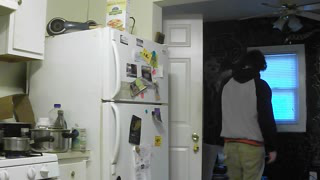

In [8]:
vid_as_imgs = Video.create(vid_as_paths)
print(vid_as_imgs)
vid_as_imgs[0]

In [9]:
#export
def snippets_from_video(vid, l=10, s=2):
    '''create list of snippet out a video'''
    vid=vid[::s] # skip frames
    return [Video([vid[i] for i in range(k*l, k*l + l)]) for k in range(0,len(vid)//l)]
        
def stretch(vid, l):
    vid = vid*(l//len(vid))
    if len(vid) == l: return vid
    lv = len(vid)
    n = l - lv                     # Number of frames to be inserted
    d = lv//n                      # Number of frames between inserted frames
    idxs = L(range(lv))
    for i in range(n):
        idxs.insert((d+1)*i, d*i)
    return vid[idxs]

class ResizeTime(Transform):
    split_idx = None # 0- train 1- validation 
    def __init__(self, skip=2, l=50, drop_last=True,**kwargs): 
        self.skip = skip
        self.l = l
        self.drop_last = drop_last
        super().__init__(**kwargs)
        
    def encodes(self, vid:Video, split_idx=split_idx):
        '''create a list of frame-images (snippet) out a single video path'''
        l, skip, l_vid = self.l, self.skip, len(vid)
        if l_vid > l*skip:
            snippet_list = snippets_from_video(vid,s=skip,l=l)
            idx = len(snippet_list)//2 if split_idx else random.randint(0,len(snippet_list)-1) # ** if validation always takes middle snip
            return snippet_list[idx]     
        else:
            vid = vid[::skip]
            vid = stretch(vid, l)         
        return vid 

In [10]:
len(ResizeTime(50)(vid_as_imgs))

50

In [11]:
#export
def _get_sz(x):
    if isinstance(x, tuple): x = x[0]
    if not isinstance(x, Tensor): return fastuple(x.size)
    return fastuple(x.get_meta('img_size', x.get_meta('sz', (x.shape[-1], x.shape[-2]))))

@Resize
def encodes(self, video:Video):
        nw_vid=[]
        for frame in video:
            orig_sz = _get_sz(frame)
            w,h = orig_sz
            op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
            m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
            cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
            tl = fastuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
            fastaiImg = PILImage.create(np.array(frame.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                       resize_mode=self.mode_mask if isinstance(frame,PILMask) else self.mode, resize_to=self.size)))
            nw_vid.append(fastaiImg)
        return Video(nw_vid)


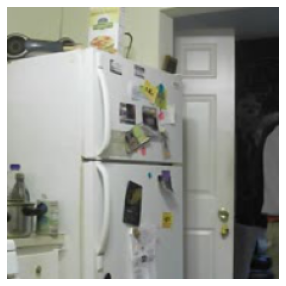

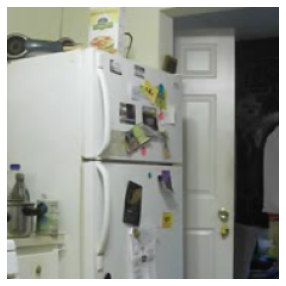

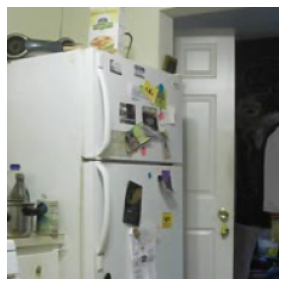

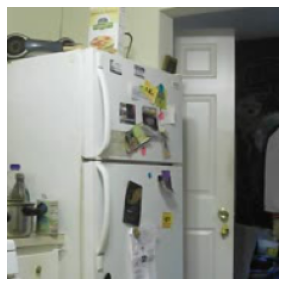

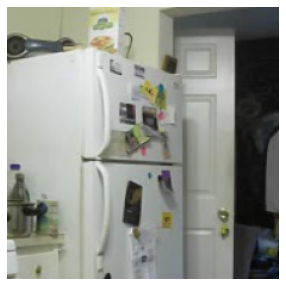

In [12]:
vid_resized = Resize(224)(vid_as_imgs)
show_frames(vid_resized, 0, 5)

In [45]:
#export
class TensorVideo(TensorBase): pass

@ToTensor
def encodes(self, vid:Video):
    return TensorVideo(vid.stack().permute(3,0,1,2))

In [46]:
vid_tensor = ToTensor()(vid_resized)
type(vid_tensor)

__main__.TensorVideo

In [47]:
#export
@IntToFloatTensor
def encodes(self, vid:TensorVideo):
    return vid.float()/self.div

In [15]:
get_paths = DF2Paths(path_charades, fps=24) if using_df0 else lambda df: df['paths']
get_lbls = lambda df: df['lbl']

vid_pl = [get_paths, Video.create]
lbl_pl = [get_lbls, Categorize()]
splits = RandomSplitter(seed=42)(df)

ds = Datasets(df, [vid_pl, lbl_pl], splits=splits)
ds[0]

((#223) [PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180,PILImage mode=RGB size=320x180...],
 TensorCategory(151))

In [16]:
#export
@delegates()
class UniformizedDataLoader(TfmdDL): 
    def __init__(self, dataset=None, n_el=4, n_lbl=4, **kwargs):
        kwargs['bs'] = n_el*n_lbl
        super().__init__(dataset, **kwargs)
        store_attr(self, 'n_el,n_lbl')
        self.lbls = list(map(int, self.dataset.tls[1]))
        self.dl_vocab = list(range(len(self.vocab)))
        
    def before_iter(self):
        super().before_iter()
        lbl2idxs = {lbl:[] for lbl in self.dl_vocab}
        for i, lbl in enumerate(self.lbls): lbl2idxs[lbl].append(i)
        
        if self.shuffle: [random.shuffle(v) for v in lbl2idxs.values()]
        self.lbl2idxs = lbl2idxs
        
    def get_labeled_elements(self, lbl, n_el):
        els_of_lbl = []
        while len(els_of_lbl) < n_el:
            item = self.do_item(self.lbl2idxs[lbl].pop())
            if item is not None: els_of_lbl.append(item) 
        return els_of_lbl
        
    def create_batches(self, samps):
        n_lbl, n_el = self.n_lbl, self.n_el
        self.it = iter(self.dataset) if self.dataset is not None else None
        
        while len(self.dl_vocab) >= n_lbl:
            
            batch_lbls, b = [], []
            
            while len(batch_lbls) < n_lbl:
                try: i = random.randint(0, len(self.dl_vocab) - 1)
                except ValueError: raise CancelBatchException
                lbl = self.dl_vocab.pop(i)
                if len(self.lbl2idxs[lbl]) < n_lbl: continue
                
                try: els_of_lbl = self.get_labeled_elements(lbl, n_el)
                except IndexError: continue
                    
                b.extend(els_of_lbl)
                batch_lbls.append(lbl)
                
            self.dl_vocab.extend(batch_lbls)
            
            yield self.do_batch(b)
            
        self.dl_vocab = list(range(len(self.vocab)))         

In [1]:
?? DataLoader.create_batches

Object ` DataLoader.create_batches` not found.


In [17]:
dls = ds.dataloaders(n_el=4, n_lbl=4,
                     after_item=[ResizeTime(l=20), Resize(128), ToTensor()],
                     after_batch=[IntToFloatTensor()],
                     dl_type=UniformizedDataLoader,
                     shuffle_train=False)
dls.bs

16

In [10]:
#export
def uniformize_dataset(items, lbls, vocab=None, n_el=3, n_lbl=3, shuffle=True):
    if vocab is None: vocab = list(set(lbls))
    lbl2idxs = {lbl:[] for lbl in vocab}
    for i, lbl in enumerate(lbls): lbl2idxs[lbl].append(i)
    for lbl, idxs in lbl2idxs.items(): 
        if len(idxs) < n_el: vocab.remove(lbl)       
    if shuffle: [random.shuffle(v) for v in lbl2idxs.values()]
    idxs = []
    while len(vocab) >= n_lbl:
        lbl_samples = random.sample(vocab, n_lbl)
        for lbl in lbl_samples:
            i = 0
            while i < n_el:
                i += 1
                idx = lbl2idxs[lbl].pop()
                idxs.append(idx)
            if len(lbl2idxs[lbl]) <= n_el:
                vocab.remove(lbl)
    return getattr(items, 'iloc', items)[idxs]

In [11]:
items = pd.read_csv(path_charades/'df0.csv', index_col=0)
items = uniformize_dataset(items, items['lbl'])
items.tail(6)

,id,coded_lbl,lbl,start,end,test
7934,4ZSAR,c059,Sitting in a chair,35.2,39.0,False
56269,ZI1GC,c059,Sitting in a chair,6.4,10.4,True
58486,NTA1U,c059,Sitting in a chair,0.0,32.0,True
39407,GWUM6,c154,Someone is standing up from somewhere,28.2,33.0,False
55031,OIL1V,c154,Someone is standing up from somewhere,9.8,15.8,True
37459,NUW2S,c154,Someone is standing up from somewhere,31.1,37.8,False


In [35]:
#export
class UniformizedShuffle():
    def __init__(self, lbls, vocab=None, n_el=4, n_lbl=4):
        self.lbls = lbls
        if vocab is None: vocab = list(set(lbls))
        self.vocab = vocab
        self.n_el = n_el
        self.n_lbl = n_lbl
    def __call__ (self, items):
        return uniformize_dataset(items, lbls=self.lbls, vocab=self.vocab, n_el=self.n_el, n_lbl=self.n_lbl)

In [39]:
df = pd.read_csv(path_charades/'df0.csv', index_col=0)
un = UniformizedShuffle(items['lbl'])
un(items).tail(7)

,id,coded_lbl,lbl,start,end,test
9944,XHL3Z,c059,Sitting in a chair,0.0,43.0,False
8341,1OIPY,c059,Sitting in a chair,0.0,7.2,False
3206,Y2QUJ,c059,Sitting in a chair,0.0,7.0,False
58706,R971Z,c154,Someone is standing up from somewhere,14.0,23.4,True
8247,2SYBS,c154,Someone is standing up from somewhere,28.7,34.0,False
15567,2YJUQ,c154,Someone is standing up from somewhere,19.4,24.3,False
24773,0FC0N,c154,Someone is standing up from somewhere,12.6,17.4,False


In [12]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_triplet_loss.ipynb.
Converted 02_inflator.ipynb.
Converted 03_video_block.ipynb.
Converted 04_distributed_inflated_NN.ipynb.
Converted 05_first_inflated_NN.ipynb.
Converted index.ipynb.


In [5]:
# default_exp video_block